# Compare ARIMA from skforecast, aeon, statsforecast and statsmodels

In [13]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [14]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from aeon.forecasting.stats import ARIMA as ARIMA_aeon
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as ARIMA_statsforecast
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.20.0


In [15]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Download data
# ==============================================================================
# from pmdarima.datasets import load_airpassengers
# y = load_airpassengers(as_series=True)
# data = pd.DataFrame(y.to_numpy(), columns=['y'], index=pd.date_range(start='1949-01-01', periods=len(y), freq='MS'))
# data

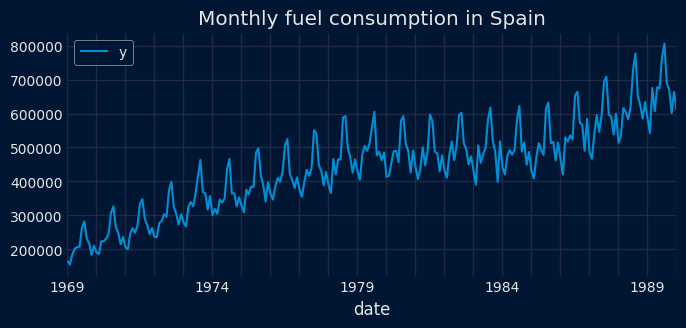

In [17]:
# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
set_dark_theme()
data['y'].plot(ax=ax)
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [18]:
order          = (1, 1, 1)
seasonal_order = (1, 1, 1)  # Non-seasonal for fair comparison
m              = 12
steps          = 12

In [19]:
# ARIMA skforecast
# ==============================================================================
estimator = Arima(
    order=order,
    seasonal_order=seasonal_order,
    m = m,
    optim_method='BFGS',
    optim_kwargs={'maxiter': 500}

)
start = timeit.default_timer()
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_skforecast = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = estimator.predict(steps=steps)
end = timeit.default_timer()
time_pred_arima_skforecast = end - start
print(f"Prediction time ARIMA skforecast: {time_pred_arima_skforecast} seconds")

Training time ARIMA skforecast  : 0.24343160500029626 seconds
Prediction time ARIMA skforecast: 0.00018771000031847507 seconds


/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2500: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


In [20]:
# ARIMA statsmodels
# ==============================================================================
# Note: statsmodels requires seasonal_periods > 1 if seasonal components are non-zero
# So we adjust the seasonal_order for statsmodels when m=1
statsmodels_seasonal = (*seasonal_order, 0 if m==1 else m) if any(seasonal_order) else (0, 0, 0, 0)
if m == 1 and any(seasonal_order):
    print("Warning: statsmodels doesn't support seasonal components with m=1, using non-seasonal model")
    statsmodels_seasonal = (0, 0, 0, 0)

estimator = Sarimax(
    order=order,
    seasonal_order=statsmodels_seasonal,
)
start = timeit.default_timer()
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_statsmodels = end - start
print(f"Training time ARIMA statsmodels  : {time_fit_arima_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = estimator.predict(steps=steps)
end = timeit.default_timer()
time_pred_arima_statsmodels = end - start
print(f"Prediction time ARIMA statsmodels: {time_pred_arima_statsmodels} seconds")

Training time ARIMA statsmodels  : 0.4878528640001605 seconds
Prediction time ARIMA statsmodels: 0.0028433870011213003 seconds


In [21]:
# ARIMA aeon
# ==============================================================================
# Aeeon ARIMA do not support seasonality nor prediction intervals
estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])
start = timeit.default_timer()
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_aeon = end - start
print(f"Training time ARIMA aeon  : {time_fit_arima_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = estimator.iterative_forecast(y=data['y'].to_numpy(), prediction_horizon=steps)
end = timeit.default_timer()
time_pred_arima_aeon = end - start
print(f"Prediction time ARIMA aeon: {time_pred_arima_aeon} seconds")

Training time ARIMA aeon  : 0.0013325170002644882 seconds
Prediction time ARIMA aeon: 0.0016424209989054361 seconds


In [22]:
# Nixtla StatsForecast Arima
# ==============================================================================
df_nixtla = data['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
estimator = ARIMA_statsforecast(order=order, seasonal_order=seasonal_order, season_length=m)
estimator.fit(y=data['y'].to_numpy())
end = timeit.default_timer()
time_fit_arima_nixtla = end - start
print(f"Training time ARIMA nixtla  : {time_fit_arima_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla = estimator.predict(h=steps)
end = timeit.default_timer()
time_pred_arima_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = pd.Series(
    predictions_nixtla['mean'],
    index=pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=steps, freq='MS')
)
print(f"Prediction time ARIMA nixtla: {time_pred_arima_nixtla} seconds")

Training time ARIMA nixtla  : 0.08190706400091585 seconds
Prediction time ARIMA nixtla: 0.0008083039992925478 seconds


In [23]:
# Table of times
# ==============================================================================
times_arima = pd.DataFrame({
    'fit_time_seconds': [time_fit_arima_skforecast, time_fit_arima_aeon, time_fit_arima_nixtla, time_fit_arima_statsmodels],
    'predict_time_seconds': [time_pred_arima_skforecast, time_pred_arima_aeon, time_pred_arima_nixtla, time_pred_arima_statsmodels]
}, index=['ARIMA skforecast', 'ARIMA aeon', 'ARIMA nixtla', 'ARIMA statsmodels'])
times_arima.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ARIMA aeon,0.001333,0.001642
ARIMA nixtla,0.081907,0.000808
ARIMA skforecast,0.243432,0.000188
ARIMA statsmodels,0.487853,0.002843


,skforecast,aeon,nixtla,statsmodels
1990-02-01,583242.381755,625626.038930,583200.930651,579063.754559
1990-03-01,678484.315716,634148.887152,678493.602775,686841.889014
1990-04-01,669613.909120,638870.363912,669593.624272,658801.540088


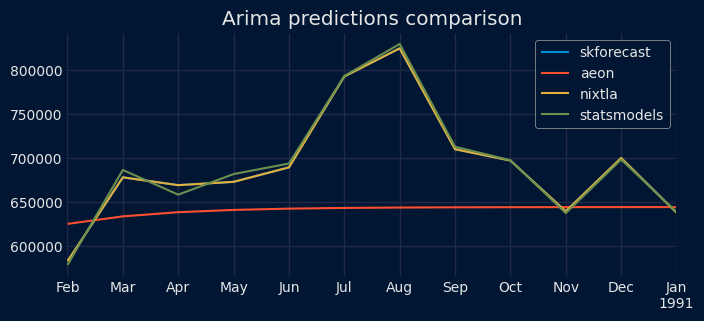

In [25]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display(predictions.head(3))
predictions.plot(figsize=(7, 3), title='Arima predictions comparison');